In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from agents import QLearningAgent
from collections import deque
from collections.abc import Iterable
import pdb

In [87]:
class DQNAgentModel(torch.nn.Module):
    def __init__(self, ip_size, op_size, lr = 0.1, gamma = 0.95):
        super().__init__()
        self.ip_size = ip_size
        self.op_size = op_size
        hidden_size = 10
        self.net = torch.nn.Sequential(
                torch.nn.Linear(ip_size, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, op_size)
        )
        self.memory = deque(maxlen=1000000)
        self.maxmemory = 1000
        self.batch_size = 128
        self.lr = lr
        self.gamma = gamma
        self.optim = torch.optim.SGD(lr = lr, params = self.parameters())
        self.criterion = torch.nn.MSELoss()
        self.losses = []
        self.steps = 0
    def forward(self, x):
        if not isinstance(x, torch.Tensor):# assumes bs 1
            x = torch.tensor(x, dtype = torch.float)
        return self.net(x)
    def get_random_memories(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        finished = []
        for i in indices:
            states.append(self.memory[i][0])
            actions.append(self.memory[i][1])
            rewards.append(self.memory[i][2])
            next_states.append(self.memory[i][3])
            finished.append(int(self.memory[i][4]))
        return {'states' :torch.tensor(states, dtype = torch.float).reshape(len(states),self.ip_size),
                'actions' : torch.tensor(actions, dtype = torch.long),
                'rewards': torch.tensor(rewards, dtype = torch.float),
                'next_states' : torch.tensor(next_states, dtype = torch.float).reshape(len(states),self.ip_size),
                'finished' : torch.tensor(finished, dtype = torch.int)
               }
    def addObservation(self,state, action, reward, next_state, finished):
        self.memory.append([state, action, reward, next_state, finished])
    def train_step(self, states, labels):
        # pdb.set_trace()
        self.steps += 1
        self.optim.zero_grad()
        pred = self.forward(states).squeeze()
#         print(pred, labels)
        loss = self.criterion(labels, pred)
        loss.backward()
        self.losses.append(loss.item())
        if self.steps % 50 == 0:
            print(f'{self.steps}: loss = {loss}')#, model = {self.net[0].weight.data.numpy()}')
        self.optim.step()
    def generate_label(self, memories):
        states = memories['states']
        actions = memories['actions']
        labels = self.forward(states)
        next_state_qvals = torch.max(self.forward(memories['next_states']), axis = 1)[0] * (1-memories['finished'])
        
        labels[range(labels.shape[0]), actions] = \
            memories['rewards'] + self.gamma * next_state_qvals
        return labels
    def replay_experiences(self):
        if len(self.memory)<self.batch_size:
            return
        memories = self.get_random_memories(self.batch_size)
        states = memories['states']
        labels = self.generate_label(memories)
#         print(states, labels)
        self.train_step(states, labels)
        
    def plot_stats(self):
        plt.plot(self.losses)

In [127]:
class DeepQLearningAgent(QLearningAgent):
    def __init__(self, state_dim, action_dim, lr = 0.01, gamma = 0.95):
        super().__init__()
        self.model = DQNAgentModel(state_dim, action_dim, lr, gamma)
    def train(self,*args,**kwargs):
        super().train(*args,**kwargs)
        self.model.train()
    def getBestAction(self,state, actions):
        if not isinstance(state, Iterable):
            state = [state]
        qVals = self.model([state])[0].data
        best_a = max(zip(qVals[actions], actions))[1]
#         print(actions,qVals, best_a)
        return best_a
    def _update(self, state, action, reward, next_state, next_state_actions, finished = False):
        # print(state, action, reward, next_state, finished)
        self.model.addObservation(state, action, reward, next_state, finished )
        self.model.replay_experiences()
        

In [128]:
import simplegame

In [129]:
all_rewards = []
all_steps = []
episodes = 100
agent = DeepQLearningAgent(1,2, lr =0.001, gamma = 0.9)
env = simplegame.OneDtarget()
for e in range(episodes):
    # print(agent.model.net[0].weight.data, agent.model.net[0].bias.data)
    agent.train(epsilon = 0.3 if e<20 else 0.1 )
    reward, steps = simplegame.playOneEpisode(env, agent, 100)
    all_rewards.append(reward)
    all_steps.append(steps)

50: loss = 0.018629372119903564
100: loss = 0.016166463494300842
150: loss = 0.015793761238455772
200: loss = 0.015534640289843082
250: loss = 0.01247616857290268
300: loss = 0.0197602491825819
350: loss = 0.020250730216503143
400: loss = 0.018174177035689354
450: loss = 0.019134776666760445
500: loss = 0.015679949894547462
550: loss = 0.012800503522157669
600: loss = 0.02061637118458748
650: loss = 0.014697887003421783
700: loss = 0.01662861742079258
750: loss = 0.026368333026766777
800: loss = 0.013714572414755821
850: loss = 0.013442857190966606
900: loss = 0.019268181174993515
950: loss = 0.0190606527030468
1000: loss = 0.016519084572792053
1050: loss = 0.011865398846566677
1100: loss = 0.016438808292150497
1150: loss = 0.018113024532794952
1200: loss = 0.011901773512363434
1250: loss = 0.015834104269742966
1300: loss = 0.011850070208311081
1350: loss = 0.017423128709197044
1400: loss = 0.007568628992885351
1450: loss = 0.018785133957862854
1500: loss = 0.016244081780314445
1550: l

Text(0.5, 1.0, 'losses')

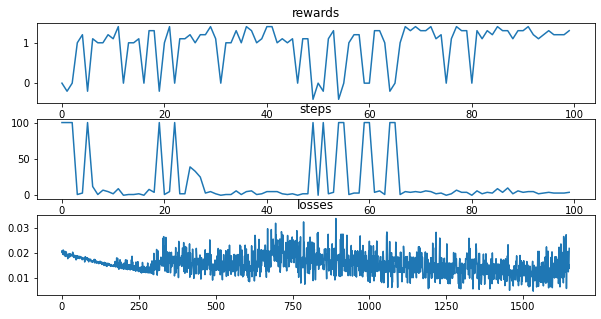

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (10,5))
ax1.plot(all_rewards)
ax1.set_title('rewards')
ax2.plot(all_steps)
ax2.set_title('steps')
ax3.plot(agent.model.losses)
ax3.set_title('losses')

In [131]:
agent.evaluate()

simplegame.playOneEpisode(env, agent, 100, render = True)

[  0   0   0   0   0 100   0   0   0   1   0]
[  0   0   0   0   0 100   0   0   1   0   0]
[  0   0   0   0   0 100   0   1   0   0   0]
[  0   0   0   0   0 100   1   0   0   0   0]
[  0   0   0   0   0 100   0   0   0   0   0]


(1.4, 5)

In [132]:
for i in range(11):
    print(i, torch.argmax(agent.model([i])))

0 tensor(1)
1 tensor(1)
2 tensor(1)
3 tensor(1)
4 tensor(1)
5 tensor(0)
6 tensor(0)
7 tensor(0)
8 tensor(0)
9 tensor(0)
10 tensor(0)


In [116]:
m = agent.model.get_random_memories(4)
m

{'states': tensor([[ 9.],
         [ 9.],
         [ 9.],
         [10.]]),
 'actions': tensor([1, 1, 1, 0]),
 'rewards': tensor([-0.1000, -0.1000, -0.1000,  0.1000]),
 'next_states': tensor([[10.],
         [10.],
         [10.],
         [ 9.]]),
 'finished': tensor([0, 0, 0, 0], dtype=torch.int32)}

In [96]:
agent.model.generate_label(m)

tensor([[ 0.2287, -0.1619],
        [ 0.1382,  0.0287],
        [ 0.1430,  0.0331],
        [ 0.2287, -0.1619]], grad_fn=<IndexPutBackward0>)

In [97]:
for i in range(11):
    print(i, agent.model([i]))

0 tensor([0.2087, 0.3870], grad_fn=<AddBackward0>)
1 tensor([0.1597, 0.3453], grad_fn=<AddBackward0>)
2 tensor([0.1031, 0.3098], grad_fn=<AddBackward0>)
3 tensor([0.1027, 0.2417], grad_fn=<AddBackward0>)
4 tensor([0.1189, 0.1703], grad_fn=<AddBackward0>)
5 tensor([0.1238, 0.1149], grad_fn=<AddBackward0>)
6 tensor([0.1286, 0.0595], grad_fn=<AddBackward0>)
7 tensor([0.1334, 0.0042], grad_fn=<AddBackward0>)
8 tensor([ 0.1382, -0.0512], grad_fn=<AddBackward0>)
9 tensor([ 0.1430, -0.1066], grad_fn=<AddBackward0>)
10 tensor([ 0.1479, -0.1619], grad_fn=<AddBackward0>)
